## Package Import

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator, ROCIndicator
from ta.trend import MACD
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import matplotlib.pyplot as plt
import warnings
import joblib
from utils import *
warnings.filterwarnings('ignore')

## Random Seed Setup

In [3]:
# Set a random seed to ensure repeatable results
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
def calculate_rolling_volatility(df, return_columns, window):
    """
    Calculate rolling volatility for each asset over a specified window.
    
    :param df: DataFrame containing return data
    :param return_columns: List of columns representing asset returns
    :param window: The rolling window period to calculate the volatility
    :return: DataFrame with rolling volatilities for each asset
    """
    vol_df = pd.DataFrame(index=df.index)
    
    for col in return_columns:
        # Calculate rolling standard deviation (volatility) for the given window
        vol_df[f'{col}_Vol'] = df[col].rolling(window=window).std()
    
    return vol_df.dropna()

def plot_volatility_thresholds(df, asset_columns, window=30):
    """
    Plot rolling volatilities and thresholds for multiple assets.

    :param df: DataFrame containing return data with 'Date' as index
    :param asset_columns: List of columns representing asset returns
    :param window: Rolling window period for volatility (default is 30)
    """
    # Ensure the index is datetime, as 'Date' is used as the index
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)
    
    # Loop through each asset column to calculate and plot its rolling volatility and thresholds
    for asset in asset_columns:
        asset_volatility = df[asset].rolling(window=window).std()

        # Define thresholds for extreme and moderate risk-on/off periods based on quantiles
        extreme_risk_on_threshold = asset_volatility.quantile(0.1)
        moderate_risk_on_threshold = asset_volatility.quantile(0.3)
        moderate_risk_off_threshold = asset_volatility.quantile(0.7)
        extreme_risk_off_threshold = asset_volatility.quantile(0.9)

        asset_volatility_clean = asset_volatility.dropna()

        # Align the dates with the cleaned volatility data
        aligned_dates = df.index[-len(asset_volatility_clean):]

        plt.figure(figsize=(10, 6))
        plt.plot(aligned_dates, asset_volatility_clean, label=f"Rolling Volatility (30-week) - {asset}", color='blue')
        plt.axhline(y=extreme_risk_off_threshold, color='red', linestyle='--', label="Extreme Risk-Off Threshold")
        plt.axhline(y=moderate_risk_off_threshold, color='orange', linestyle='--', label="Moderate Risk-Off Threshold")
        plt.axhline(y=moderate_risk_on_threshold, color='green', linestyle='--', label="Moderate Risk-On Threshold")
        plt.axhline(y=extreme_risk_on_threshold, color='purple', linestyle='--', label="Extreme Risk-On Threshold")
        plt.title(f'Volatility-Based Regime Switching: {asset}')
        plt.xlabel('Date')
        plt.ylabel('Rolling Volatility')
        plt.legend()
        plt.tight_layout()
        plt.show()

$$\text{Portfolio Volatility} = \sqrt{\sum^n_{i = 1}\sum^n_{j = 1}\omega_i\omega_j Cov(\sigma_i, \sigma_j)}$$
Equal weights in default.

In [5]:
def calculate_portfolio_volatility(df, asset_columns, window=52, weights=None):
    # Ensure the index is datetime, as 'Date' is used as the index
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df['Date'])
    
    num_assets = len(asset_columns)
    
    # Assign equal weights if no weights are provided
    if weights is None:
        weights = np.ones(num_assets) / num_assets
    
    # Ensure weights sum to 1
    weights = np.array(weights)
    if not np.isclose(weights.sum(), 1):
        raise ValueError("Weights must sum to 1.")
    
    # Covariance Matrix
    rolling_cov = df[asset_columns].rolling(window=window).cov()

    portfolio_volatility = []

    for i in range(window, len(df)):
        # Extract the covariance matrix for the current time point
        cov_matrix = rolling_cov.loc[df.index[i]].values.reshape((num_assets, num_assets))

        # Calculate the portfolio variance (weights * cov_matrix * weights.T)
        portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))

        # Calculate the portfolio volatility (square root of variance)
        portfolio_volatility.append(np.sqrt(portfolio_variance))

    portfolio_volatility_series = pd.Series(portfolio_volatility, index=df.index[window:])

    return portfolio_volatility_series

## Data Import

In [6]:
# Load data
data_path = os.path.dirname(os.getcwd()) + '/data'
data_prefix = '/broad_assets_'

target_file = data_path + data_prefix + 'weekly_rets.xlsx'
lag1_file = data_path + data_prefix + 'lag1_rets.xlsx'
roc_file = data_path + data_prefix + 'roc_52w.xlsx'
macd_file = data_path + data_prefix + 'macd.xlsx'
rsi_file = data_path + data_prefix + 'rsi.xlsx'
ewma_file = data_path + data_prefix + 'ewma_vol.xlsx'
skew_file = data_path + data_prefix + 'skew.xlsx'
kurtosis_file = data_path + data_prefix + 'kurtosis.xlsx'

names = ['target', 'lag1', 'roc', 'macd', 'rsi', 'ewma', 'skew', 'kurtosis']
files = [target_file, lag1_file, roc_file, macd_file, rsi_file, ewma_file, skew_file, kurtosis_file]
dfs = {}
for name, file in zip(names, files):
    dfs[name] = pd.read_excel(file, sheet_name=0, index_col=0, parse_dates=True)

In [7]:
# Get intersection of dates across datasets
dates_inter = reduce(lambda x, y: set(x).intersection(y.index), list(dfs.values())[1:], list(dfs.values())[0].index)
dates_inter = sorted(list(dates_inter))
print(f'Count: {len(dates_inter)}\nFirst: {dates_inter[0]}\nLast:{dates_inter[-1]}')

Count: 1101
First: 2003-08-11 00:00:00
Last:2024-09-06 00:00:00


In [8]:
for name, frame in dfs.items():
    dfs[name] = frame.loc[dates_inter]

## Auxiliary Outputs

### 1. Momentum Indicators (ROC, MACD, RSI)

In [9]:
display(dfs['roc'].head(), dfs['macd'].head(), dfs['rsi'].head())

,ROC_Asset 1,ROC_Asset 2,ROC_Asset 3,ROC_Asset 4,ROC_Asset 5,ROC_Asset 6,ROC_Asset 7,ROC_Asset 8,ROC_Asset 9,ROC_Asset 10,ROC_Asset 11
Date,,,,,,,,,,,
2003-08-11,0.140818,0.494435,0.046476,0.081370,0.346667,0.168040,0.084823,0.395669,-0.227221,0.272958,0.302730
2003-08-18,0.074442,0.389057,0.031290,0.081003,0.386236,0.158586,0.033946,0.450668,-0.205088,0.310755,0.229929
2003-08-25,0.068957,0.466459,0.016618,0.054283,0.360390,0.094813,0.030266,0.487322,-0.184408,0.308609,0.227753
2003-08-29,0.178558,0.805035,0.025455,0.061091,0.565285,0.126215,0.072788,0.549216,-0.185119,0.383965,0.255372
2003-09-08,0.273776,0.983880,0.015629,0.066612,0.682310,0.201070,0.281106,0.787957,-0.201124,0.309744,0.120741


,MACD_Line_Asset 1,Signal_Line_Asset 1,MACD_Histogram_Asset 1,MACD_Line_Asset 2,Signal_Line_Asset 2,MACD_Histogram_Asset 2,MACD_Line_Asset 3,Signal_Line_Asset 3,MACD_Histogram_Asset 3,MACD_Line_Asset 4,...,MACD_Histogram_Asset 8,MACD_Line_Asset 9,Signal_Line_Asset 9,MACD_Histogram_Asset 9,MACD_Line_Asset 10,Signal_Line_Asset 10,MACD_Histogram_Asset 10,MACD_Line_Asset 11,Signal_Line_Asset 11,MACD_Histogram_Asset 11
Date,,,,,,,,,,,,,,,,,,,,,
2003-08-11,0.000565,-0.000882,0.001447,-0.002008,-0.003546,0.001537,0.001538,0.000800,0.000738,0.001256,...,0.001429,-0.000897,-0.000322,-0.000575,0.003432,0.000609,0.002823,0.000480,0.001251,-0.000771
2003-08-18,0.002485,0.000868,0.001617,0.005460,0.000628,0.004833,0.001768,0.000569,0.001199,0.000828,...,0.002690,0.001309,0.000265,0.001044,-0.001362,0.000965,-0.002328,-0.001049,-0.000191,-0.000858
2003-08-25,-0.000416,0.000647,-0.001063,0.002130,0.002724,-0.000594,0.001291,0.001789,-0.000498,0.000198,...,-0.001128,0.001513,0.001221,0.000292,-0.000948,0.000230,-0.001178,-0.000500,-0.000114,-0.000386
2003-08-29,0.001419,0.000696,0.000723,0.003082,0.002675,0.000407,0.002342,0.002099,0.000242,0.001294,...,0.000018,-0.001292,0.000478,-0.001771,0.003463,0.001554,0.001908,0.000009,-0.000246,0.000255
2003-09-08,0.001937,0.001623,0.000314,0.002982,0.002674,0.000307,0.002579,0.001812,0.000767,0.002331,...,0.001165,-0.002370,-0.000961,-0.001409,0.000156,0.001078,-0.000923,-0.002609,-0.002104,-0.000505


,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,Asset 8,Asset 9,Asset 10,Asset 11
Date,,,,,,,,,,,
2003-08-11,46.265533,40.516298,37.381934,42.709992,44.947278,56.083146,65.018332,57.007764,44.745429,61.405033,80.971909
2003-08-18,57.261623,52.946953,45.531631,47.951287,57.182389,48.235151,61.804119,67.728192,67.629462,46.778314,66.080873
2003-08-25,72.581668,76.114361,54.340656,49.662957,74.313504,45.003001,60.788052,81.663075,76.645470,60.226587,58.803545
2003-08-29,71.977477,92.635075,52.590118,47.050984,82.257880,57.741746,41.251782,78.034827,75.522695,62.316895,59.612844
2003-09-08,73.225184,84.842934,59.029965,58.669104,77.783223,71.032656,59.141756,82.548599,48.272783,67.282652,43.054056


### Dynamic Asset Selection Algorithm on Portfolio Volatility with Rolling Quantiles

#### 1. Setup
- Inputs:
1. Asset return data (weekly returns for multiple assets).
2. Rolling quantile window sizes: 26 weeks and 52 weeks (for threshold determination).
3. Portfolio volatility window sizes: 13 weeks and 26 weeks (for volatility calculation).

- Goal: Allocate assets dynamically based on the calculated risk levels from rolling portfolio volatility and rolling quantile thresholds. The algorithm should shift asset weights according to changing risk levels, focusing on reducing risk during high volatility periods and increasing exposure during low volatility periods.

#### 2. Rolling Volatility Calculation

Calculate rolling portfolio volatility for each week using two different rolling windows:
Short-term volatility: Rolling window of 13 weeks.
Medium-term volatility: Rolling window of 26 weeks.

$$\text{Volatility}_t = \sqrt{W^T\Sigma_t W}$$
- $W$ is the vector of asset weights (equal weights).
- $\Sigma_t$ is the covariance matrix of asset returns over the rolling window (either 13 or 26 weeks).

#### 3. Rolling Quantile Calculation
Use two different rolling windows (26 weeks and 52 weeks) to calculate quantile thresholds for the portfolio volatility (Quantiles: 10th, 30th, 70th, and 90th percentiles). Calculate these quantiles for each rolling window period (26 weeks and 52 weeks).

#### 4. Assign Risk Levels
Compare the current rolling portfolio volatility (from Step 1) to the rolling quantile thresholds (from Step 2) to assign risk levels.

Risk Levels:

- Extremely Low Risk: If volatility is below the 10th percentile (Light Green).
- Moderately Low Risk: If volatility is between the 10th and 30th percentiles (Green).
- Moderately High Risk: If volatility is between the 30th and 70th percentiles (Orange).
- Extremely High Risk: If volatility is above the 90th percentile (Red).

Dynamic Allocation suggestions:

Low Risk (Extremely Low Risk or Moderately Low Risk): Increase more assets to invest.
High Risk (Moderately High Risk or Extremely High Risk): Invest less assets and shift to safer assets.

- `quantile_rolling_window_size = 26`
- `portfolio_volatility_rolling_window_size = 13`

In [10]:
asset_columns = [col for col in dfs['ewma'].columns if col.startswith('EWMA_vol_')]
rolling_window_size = 26 # Set the rolling window to be half year.

# Function to calculate rolling quantiles for volatility thresholds
def calculate_rolling_quantiles(df, asset_columns, window=13, quantiles=[0.1, 0.3, 0.7, 0.9]):
    """
    Calculate rolling quantiles for portfolio volatility over a given window.
    
    :param df: DataFrame containing volatility data
    :param asset_columns: List of columns representing asset volatilities
    :param window: Rolling window period (default is 0.5 year, assuming weekly data, i.e., 26 weeks)
    :param quantiles: Quantiles to calculate for the rolling volatility (default [0.1, 0.3, 0.7, 0.9])
    :return: DataFrame of rolling quantiles
    """
    rolling_quantiles_df = pd.DataFrame(index=df.index[window:], columns=quantiles)
    
    for i in range(window, len(df)):
        rolling_data = df.iloc[i-window:i]
        rolling_volatility = calculate_portfolio_volatility(rolling_data, asset_columns, window=13)
        rolling_quantiles = rolling_volatility.quantile(quantiles)
        rolling_quantiles_df.loc[df.index[i]] = rolling_quantiles.values

    return rolling_quantiles_df

def assign_rolling_risk_levels(vol_series, rolling_quantiles):
    risk_levels = []
    
    for i in range(len(vol_series)):
        if i >= len(rolling_quantiles):
            risk_levels.append(None)
        else:
            quantiles = rolling_quantiles.iloc[i]
            vol = vol_series.iloc[i]
            if vol > quantiles[0.9]:
                risk_levels.append('Extremely High Risk')
            elif vol > quantiles[0.7]:
                risk_levels.append('Moderately High Risk')
            elif vol > quantiles[0.3]:
                risk_levels.append('Moderately Low Risk')
            else:
                risk_levels.append('Extremely Low Risk')
    
    return pd.Series(risk_levels, index=vol_series.index)

In [11]:
ewma_weekly_vol = dfs['ewma'].reset_index()

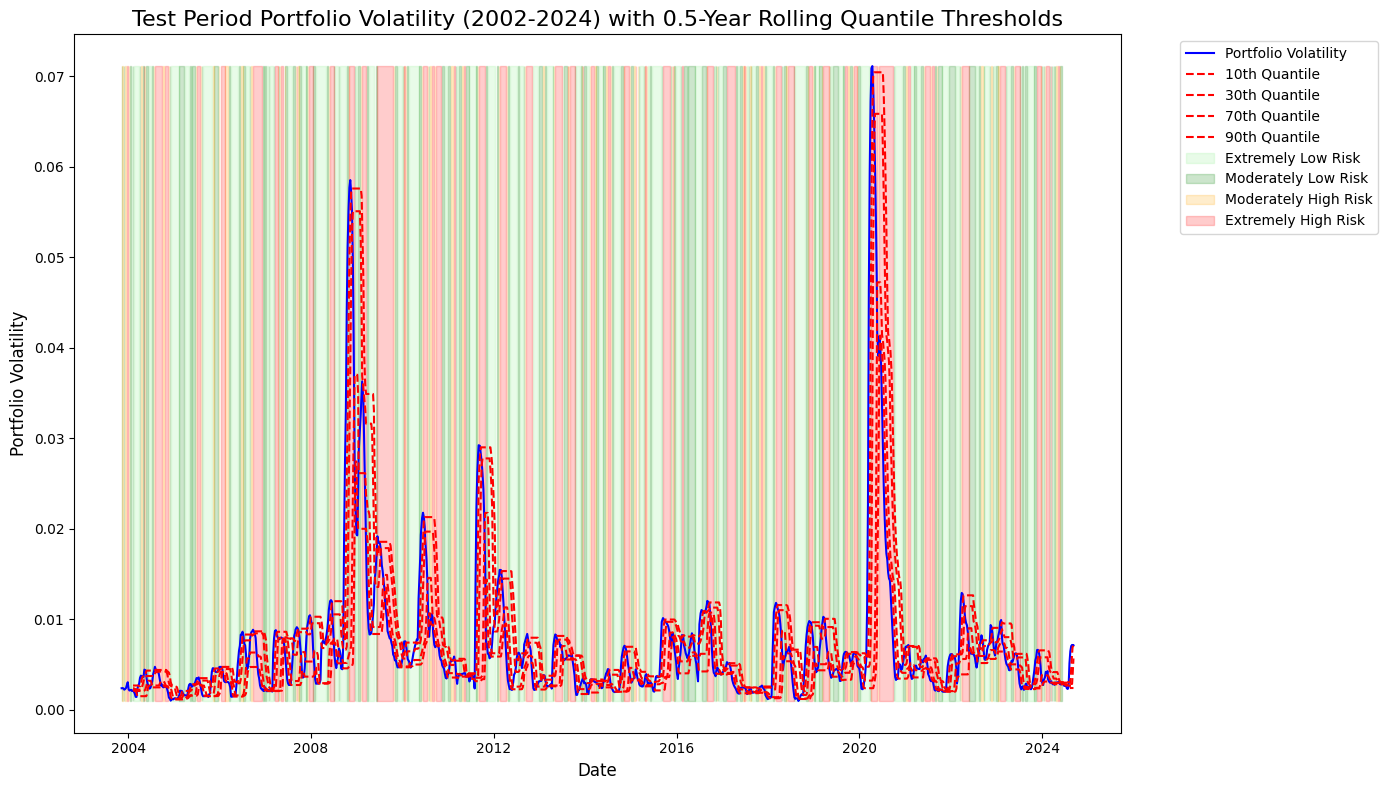

In [12]:
# Filter the data for the time range 2002 to 2024
test_period_data = ewma_weekly_vol[(ewma_weekly_vol['Date'] >= '2002-01-01') & (ewma_weekly_vol['Date'] <= '2024-12-31')]
# Calculate portfolio volatility for the test period
test_period_volatility_series = calculate_portfolio_volatility(test_period_data, asset_columns, window=13)
# Calculate rolling quantiles for the test period with 0.5-year rolling window
rolling_quantile_thresholds_test = calculate_rolling_quantiles(test_period_data, asset_columns, window=rolling_window_size)
# Assign risk levels for the test period using rolling quantiles
rolling_risk_levels_test = assign_rolling_risk_levels(test_period_volatility_series, rolling_quantile_thresholds_test)

# Create DataFrame for the test period portfolio volatility and risk levels based on rolling quantiles
test_period_risk_rolling_df = pd.DataFrame({
    'Portfolio Volatility': test_period_volatility_series, 
    'Risk Level': rolling_risk_levels_test
})

# Plotting the test period portfolio volatility with 0.5-year rolling quantiles and risk levels
plt.figure(figsize=(14, 8))
plt.plot(test_period_risk_rolling_df.index, test_period_risk_rolling_df['Portfolio Volatility'], color='blue', label='Portfolio Volatility')

# Add rolling quantiles as horizontal lines
for quantile in [0.1, 0.3, 0.7, 0.9]:
    plt.plot(rolling_quantile_thresholds_test.index, rolling_quantile_thresholds_test[quantile], color='red', linestyle='--', label=f'{int(quantile*100)}th Quantile')

# Define risk level colors
risk_colors = {
    'Extremely Low Risk': 'lightgreen',
    'Moderately Low Risk': 'green',
    'Moderately High Risk': 'orange',
    'Extremely High Risk': 'red'
}

# Fill the different risk levels with colors for the test period based on rolling quantiles
for risk_level, color in risk_colors.items():
    plt.fill_between(test_period_risk_rolling_df.index, test_period_risk_rolling_df['Portfolio Volatility'].min(), 
                     test_period_risk_rolling_df['Portfolio Volatility'].max(),
                     where=test_period_risk_rolling_df['Risk Level'] == risk_level,
                     color=color, alpha=0.2, label=risk_level)

plt.title('Test Period Portfolio Volatility (2002-2024) with 0.5-Year Rolling Quantile Thresholds', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Volatility', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Dynamic Asset Selection Algorithm on Portfolio Volatility with Rolling Quantiles
- `quantile_rolling_window_size = 52`
- `portfolio_volatility_rolling_window_size = 26`

In [13]:
asset_columns = [col for col in dfs['ewma'].columns if col.startswith('EWMA_vol_')]
rolling_window_size = 52 # Set the rolling window to be 1 year.

# Function to calculate rolling quantiles for volatility thresholds
def calculate_rolling_quantiles(df, asset_columns, window=26, quantiles=[0.1, 0.3, 0.7, 0.9]):
    """
    Calculate rolling quantiles for portfolio volatility over a given window.
    
    :param df: DataFrame containing volatility data
    :param asset_columns: List of columns representing asset volatilities
    :param window: Rolling window period (default is half year, assuming weekly data, i.e., 26 weeks)
    :param quantiles: Quantiles to calculate for the rolling volatility (default [0.1, 0.3, 0.7, 0.9])
    :return: DataFrame of rolling quantiles
    """
    rolling_quantiles_df = pd.DataFrame(index=df.index[window:], columns=quantiles)
    
    for i in range(window, len(df)):
        rolling_data = df.iloc[i-window:i]
        rolling_volatility = calculate_portfolio_volatility(rolling_data, asset_columns, window=26)
        rolling_quantiles = rolling_volatility.quantile(quantiles)
        rolling_quantiles_df.loc[df.index[i]] = rolling_quantiles.values

    return rolling_quantiles_df

def assign_rolling_risk_levels(vol_series, rolling_quantiles):
    risk_levels = []
    
    for i in range(len(vol_series)):
        if i >= len(rolling_quantiles):
            risk_levels.append(None)
        else:
            quantiles = rolling_quantiles.iloc[i]
            vol = vol_series.iloc[i]
            if vol > quantiles[0.9]:
                risk_levels.append('Extremely High Risk')
            elif vol > quantiles[0.7]:
                risk_levels.append('Moderately High Risk')
            elif vol > quantiles[0.3]:
                risk_levels.append('Moderately Low Risk')
            else:
                risk_levels.append('Extremely Low Risk')
    
    return pd.Series(risk_levels, index=vol_series.index)

In [14]:
ewma_weekly_vol = dfs['ewma'].reset_index()

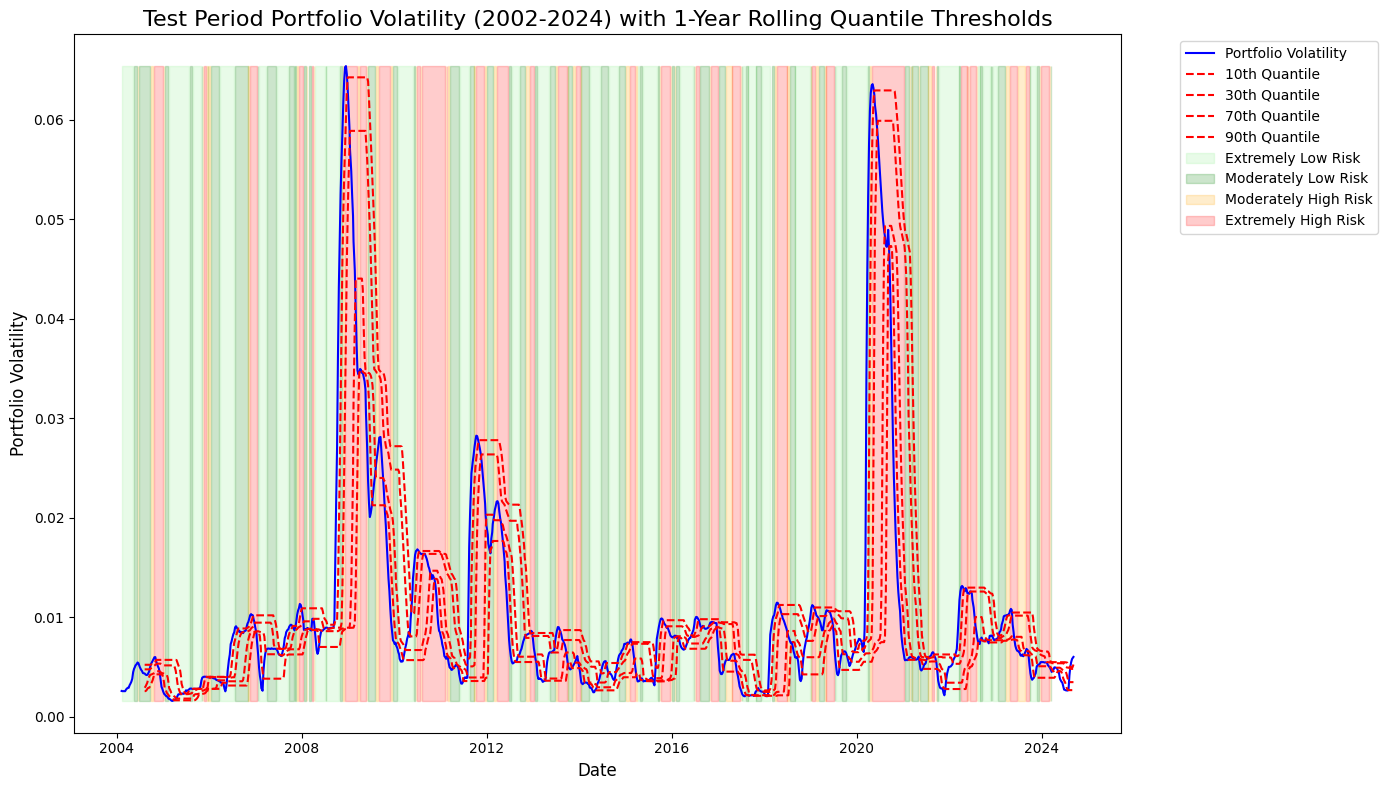

In [15]:
# Filter the data for the time range 2002 to 2024
test_period_data = ewma_weekly_vol[(ewma_weekly_vol['Date'] >= '2002-01-01') & (ewma_weekly_vol['Date'] <= '2024-12-31')]
# Calculate portfolio volatility for the test period
test_period_volatility_series = calculate_portfolio_volatility(test_period_data, asset_columns, window=26)
# Calculate rolling quantiles for the test period with 1-year rolling window
rolling_quantile_thresholds_test = calculate_rolling_quantiles(test_period_data, asset_columns, window=rolling_window_size)
# Assign risk levels for the test period using rolling quantiles
rolling_risk_levels_test = assign_rolling_risk_levels(test_period_volatility_series, rolling_quantile_thresholds_test)

# Create DataFrame for the test period portfolio volatility and risk levels based on rolling quantiles
test_period_risk_rolling_df = pd.DataFrame({
    'Portfolio Volatility': test_period_volatility_series, 
    'Risk Level': rolling_risk_levels_test
})

# Plotting the test period portfolio volatility with 1-year rolling quantiles and risk levels
plt.figure(figsize=(14, 8))
plt.plot(test_period_risk_rolling_df.index, test_period_risk_rolling_df['Portfolio Volatility'], color='blue', label='Portfolio Volatility')

# Add rolling quantiles as horizontal lines
for quantile in [0.1, 0.3, 0.7, 0.9]:
    plt.plot(rolling_quantile_thresholds_test.index, rolling_quantile_thresholds_test[quantile], color='red', linestyle='--', label=f'{int(quantile*100)}th Quantile')

# Define risk level colors
risk_colors = {
    'Extremely Low Risk': 'lightgreen',
    'Moderately Low Risk': 'green',
    'Moderately High Risk': 'orange',
    'Extremely High Risk': 'red'
}

# Fill the different risk levels with colors for the test period based on rolling quantiles
for risk_level, color in risk_colors.items():
    plt.fill_between(test_period_risk_rolling_df.index, test_period_risk_rolling_df['Portfolio Volatility'].min(), 
                     test_period_risk_rolling_df['Portfolio Volatility'].max(),
                     where=test_period_risk_rolling_df['Risk Level'] == risk_level,
                     color=color, alpha=0.2, label=risk_level)

plt.title('Test Period Portfolio Volatility (2002-2024) with 1-Year Rolling Quantile Thresholds', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Volatility', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()